In [1]:
import gc
import io
import math
import sys

from IPython import display
import lpips
from PIL import Image
import requests
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm

sys.path.append('../diffusion/CLIP')
sys.path.append('../diffusion/guided-diffusion')
sys.path.append('../lib')

import clip
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults

import os
from pathlib import Path
import importlib 
import numpy as np

import data as anime_data
importlib.reload(anime_data)

from torch.utils.data import DataLoader

In [2]:
from utils import fetch,parse_prompt,MakeCutouts,spherical_dist_loss,tv_loss,range_loss,mse_loss_batch

In [3]:
model_config = model_and_diffusion_defaults()
model_config.update({
    'attention_resolutions': '32, 16, 8',
    'class_cond': False,
    'diffusion_steps': 1000,
    'rescale_timesteps': True,
    'timestep_respacing': '800',  # Modify this value to decrease the number of
                                   # timesteps.
    'image_size': 256,
    'learn_sigma': True,
    'noise_schedule': 'linear',
    'num_channels': 256,
    'num_head_channels': 64,
    'num_res_blocks': 2,
    'resblock_updown': True,
    'use_checkpoint': False,
    'use_fp16': True,
    'use_scale_shift_norm': True,
})

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load('256x256_diffusion_uncond.pt', map_location='cpu'))
model.requires_grad_(False).eval().to(device)
if model_config['use_fp16']:
    model.convert_to_fp16()

clip_model = clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device)
clip_size = clip_model.visual.input_resolution
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

#  LPIPS Model for Perceptual Similarity
lpips_model = lpips.LPIPS(net='vgg').to(device)

project_main_path = Path.cwd().parent
assert project_main_path.name == 'EC523_Project_G'

added_path = os.path.abspath(project_main_path.__str__())

if added_path not in os.sys.path:
    os.sys.path.append(added_path)  
PHASE3_SCENE_DESCRIPTION_FILE = "./DATASET/PROCESSING_RECORD_PHASE3_SCENE_DESCRIPTION_test.json"
dataset_path = os.path.abspath(project_main_path) 

MAX_NUM_FIGURE=1

data_path_dict, anime_figure_scene_dataset = anime_data.get_dataset(PHASE3_SCENE_DESCRIPTION_FILE, dataset_path=dataset_path, MAX_NUM_FIGURE=MAX_NUM_FIGURE)

# convert anime_figure_scene_dataset to dataloader

train_loader = DataLoader(anime_figure_scene_dataset, batch_size=4, shuffle=True)

Using device: cuda:0
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


d:\Anaconda\envs\control\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\envs\control\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: d:\Anaconda\envs\control\lib\site-packages\lpips\weights\v0.1\vgg.pth
Start Loading Metadata...
series_name: usagi_s1_
series_name: cute
Finish Loading Metadata...


In [14]:
# # read json file
# import json
# # combine PHASE3_SCENE_DESCRIPTION_FILE and dataset_path
# jason_path = os.path.join(dataset_path, PHASE3_SCENE_DESCRIPTION_FILE)
# file = open(jason_path, 'r')
# # get key of the json file
# json_dict = json.load(file)
# json_dict_copy = json_dict.copy()

# # only keep json_dict["dataset_dict"]["usagi_s1_"]["usagi_s1_12"] and json_dict["dataset_dict"]["cute"]["cute16"]
# new_json_dict = {}
# new_json_dict["dataset_dict"] = {}
# new_json_dict["dataset_dict"]["usagi_s1_"] = {}
# new_json_dict["dataset_dict"]["usagi_s1_"]["usagi_s1_12"] = json_dict_copy["dataset_dict"]["usagi_s1_"]["usagi_s1_12"]
# new_json_dict["dataset_dict"]["cute"] = {}
# new_json_dict["dataset_dict"]["cute"]["cute16"] = json_dict_copy["dataset_dict"]["cute"]["cute16"]
# # write the new json file
# new_jason_path = os.path.join(dataset_path, "PROCESSING_RECORD_PHASE3_SCENE_DESCRIPTION_test.json")
# # save the new json file
# with open(new_jason_path, 'w') as f:
#     json.dump(new_json_dict, f)

# # remove json_dict["dataset_dict"]["usagi_s1_"]["usagi_s1_12"] and json_dict["dataset_dict"]["cute"]["cute16"] from the original json file
# json_dict_copy["dataset_dict"]["usagi_s1_"].pop("usagi_s1_12")
# json_dict_copy["dataset_dict"]["cute"].pop("cute16")
# new_jason_path = os.path.join(dataset_path, "PROCESSING_RECORD_PHASE3_SCENE_DESCRIPTION_train.json")
# # save the new json file
# with open(new_jason_path, 'w') as f:
#     json.dump(json_dict_copy, f)



In [14]:
# CHECK IF THE DATA LOADER WORKS
for batch in train_loader:
    print(batch['scene_img'].shape)
    break

torch.Size([4, 3, 256, 256])


In [6]:
batch_size = 1
clip_guidance_scale = 500  # Controls how much the image should look like the prompt.
tv_scale = 150              # Controls the smoothness of the final output.
range_scale = 50            # Controls how far out of range RGB values are allowed to be.
cutn = 16
n_batches = 1             # Number of batches to generate. 1 batch = 1 image.
skip_timesteps = 0  # This needs to be between approx. 200 and 500 when using an init image.
                    # Higher values make the output look more like the init.
init_scale = 100      # This enhances the effect of the init image, a good value is 1000.
mse_guidance_scale = 200 # Controls how much the image should look like the ground true image.
seed = 0

In [7]:
def do_run_single(data, prompt_weight = 1, character_weight = 1):
    if seed is not None:
        torch.manual_seed(seed)

    make_cutouts = MakeCutouts(clip_size, cutn)
    side_x = side_y = model_config['image_size']

    target_embeds, weights = [], []

    # get text
    txt = data['description']
    target_embeds.append(clip_model.encode_text(clip.tokenize(txt,truncate=True).to(device)).float())
    weights.append(prompt_weight)

    # get character image
    img = data["figure_img_list"][0].transpose(1, 2, 0)
    img = ((img + 0.5) * 255).astype(np.uint8)
    img = Image.fromarray(img).convert('RGB')
    batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
    embed = clip_model.encode_image(normalize(batch)).float()
    target_embeds.append(embed)
    weights.extend([character_weight / cutn] * cutn)
    
    target_embeds = torch.cat(target_embeds)
    weights = torch.tensor(weights, device=device)
    if weights.sum().abs() < 1e-3:
        raise RuntimeError('The weights must not sum to 0.')
    weights /= weights.sum().abs()

    # get inpainting_img image
    init = data["inpainting_img"].transpose(1, 2, 0)
    init = ((init + 0.5) * 255).astype(np.uint8)
    init = Image.fromarray(init).convert('RGB')
    init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)

    # get ground truth image
    ground_truth_img = data["scene_img"].transpose(1, 2, 0)
    ground_truth_img = ((ground_truth_img + 0.5) * 255).astype(np.uint8)
    ground_truth_img = Image.fromarray(ground_truth_img).convert('RGB')
    ground_truth_img = TF.to_tensor(ground_truth_img).to(device).unsqueeze(0).mul(2).sub(1)

    cur_t = None

    def cond_fn(x, t, out, y=None):
        n = x.shape[0]
        fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
        x_in = out['pred_xstart'] * fac + x * (1 - fac)
        clip_in = normalize(make_cutouts(x_in.add(1).div(2)))
        image_embeds = clip_model.encode_image(clip_in).float()
        dists = spherical_dist_loss(image_embeds.unsqueeze(1), target_embeds.unsqueeze(0))
        dists = dists.view([cutn, n, -1])
        losses = dists.mul(weights).sum(2).mean(0)
        tv_losses = tv_loss(x_in)
        range_losses = range_loss(out['pred_xstart'])
        
        # Compute the MSE loss with the ground truth
        mse_loss = mse_loss_batch(x_in, ground_truth_img.expand_as(x_in))
        
        loss = losses.sum() * clip_guidance_scale + tv_losses.sum() * tv_scale + range_losses.sum() * range_scale # + mse_loss * mse_guidance_scale
        if init is not None and init_scale:
            init_losses = lpips_model(x_in, init)
            loss = loss + init_losses.sum() * init_scale
        return -torch.autograd.grad(loss, x)[0]

    if model_config['timestep_respacing'].startswith('ddim'):
        sample_fn = diffusion.ddim_sample_loop_progressive
    else:
        sample_fn = diffusion.p_sample_loop_progressive

    for i in range(n_batches):
        cur_t = diffusion.num_timesteps - skip_timesteps - 1

        samples = sample_fn(
            model,
            (batch_size, 3, side_y, side_x),
            clip_denoised=False,
            model_kwargs={},
            cond_fn=cond_fn,
            progress=True,
            skip_timesteps=skip_timesteps,
            init_image=init,
            randomize_class=True,
            cond_fn_with_grad=True,
        )

        for j, sample in enumerate(samples):
            cur_t -= 1
            if j % 100 == 0 or cur_t == -1:
                print()
                for k, image in enumerate(sample['pred_xstart']):
                    filename = f'progress_{i * batch_size + k:05}.png'
                    TF.to_pil_image(image.add(1).div(2).clamp(0, 1)).save(filename)
                    #tqdm.write(f'Batch {i}, step {j}, output {k}:')
                    #display.display(display.Image(filename))

gc.collect()
do_run_single(anime_figure_scene_dataset[4])

d:\Anaconda\envs\control\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


AssertionError: 

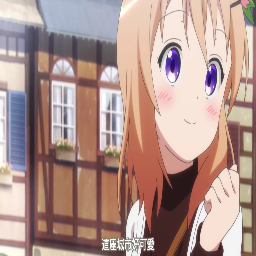

In [ ]:
ground_truth_img = anime_figure_scene_dataset[4]["scene_img"].transpose(1, 2, 0)
ground_truth_img = ((ground_truth_img + 0.5) * 255).astype(np.uint8)
ground_truth_img = Image.fromarray(ground_truth_img).convert('RGB')
ground_truth_img